In [14]:
%load_ext autoreload
%autoreload 2

import dolfin
import numpy
import sympy
import scipy.optimize
from scipy.interpolate import interp1d

import dolfin_mech     as dmech
import matplotlib.pyplot as plt
import micro_poro_structure_generator as gen
from numpy import linspace
from sympy import lambdify
from shapely.geometry import LineString

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
smith_gamma_0_inf = numpy.array([
[0.10261460510291531, 10.12867762052346],
[1.0670404781958325, 14.37579169470247],
[1.8163827631860017, 17.871672403295065],
[1.9748719391855454, 19.573866563700566],
[2.1594615644511066, 22.10912106780112],
[2.5164854274353257, 27.42241317661467],
[2.9066567368768337, 34.04958685994136],
[3.3937484592561367, 43.15381056445911],
[3.9145957698017324, 52.5539186331707],
[4.541473207864893, 60.481952639401214],
[5.217917918528443, 68.62351762513866],
[6.241172193676007, 77.1946779015478],
[7.261758091937126, 83.31499516204023],
[8.569970196446437, 88.40221757910093],
[9.93786458361406, 92.1302691779124],
[11.647661204005693, 95.2594309371248],
[13.021679205851322, 96.96864019630578],
[14.650664963066118, 98.82977258733175],
[16.227410106371963, 100.22737839699602]])

p_smith_gamma_0_inf = smith_gamma_0_inf[:, 0]
v_smith_gamma_0_inf = smith_gamma_0_inf[:, 1]


smith_gamma_0_inf_reduced = numpy.array([
[0.10261460510291531, 10.12867762052346],
[1.8163827631860017, 17.871672403295065],
[2.1594615644511066, 22.10912106780112],
[2.9066567368768337, 34.04958685994136],
[3.9145957698017324, 52.5539186331707],
[5.217917918528443, 68.62351762513866],
[7.261758091937126, 83.31499516204023],
[9.93786458361406, 92.1302691779124],
[13.021679205851322, 96.96864019630578],
[16.227410106371963, 100.22737839699602]])




smith_gamma_0_def = numpy.array([
[0.005402644675070236, 9.624888713050963],
[0.1668047591213219, 13.336914018852813],
[0.4784246543693627, 17.576913749523595],
[0.7895795886163685, 22.629626469396946],
[1.049528165662428, 26.98978789511438],
[1.4526998927990538, 32.2156737299415],
[1.807379219882079, 37.46576576043189],
[2.0644723299109122, 42.66182849231477],
[2.3007533812195033, 46.81773063897312],
[2.509263120564099, 50.627115670978604],
[2.7535495873687714, 53.840855918968124],
[3.033910963145054, 58.58295961002058],
[3.3518634250702353, 62.883333664190346],
[3.6492919019388586, 66.62339892776788],
[3.9266765165237323, 69.96982003584168],
[4.321256572989058, 74.121866131073],
[4.807696750702351, 77.78184588726738],
[5.332289000120139, 81.33215478582349],
[6.19081927283565, 85.6636911592568],
[7.169511640775174, 89.30143732413063],
[8.129095122356942, 92.16244173869191],
[9.204640888381636, 94.35632139473529],
[10.399191401051679, 96.39406440195621],
[11.51269213574782, 97.66598370813628],
[12.540963497384666, 98.63105344989252],
[13.656157296595447, 99.30917055539747],
[14.80094434734493, 99.84170685998932],
[16.163451913791032, 100.36715330509323]])

p_smith_gamma_0_def = smith_gamma_0_def[:, 0]
v_smith_gamma_0_def = smith_gamma_0_def[:, 1]



exp_gamma_3 = numpy.array([
[1.6288365063673362, 18.24863575608071],
[1.7445485979253694, 20.490790357886954],
[1.8851788588762188, 23.610864207005015],
[2.1028121439849703, 27.408441019971562],
[2.345817914022899, 31.364391233826012],
[2.686891267148298, 36.33093284872562],
[3.0152483975960482, 40.68289193502607],
[3.3079129313114883, 45.87973755402032],
[3.688211933969734, 51.39684496806957],
[4.073722881359841, 56.72554052014706],
[4.2930465892510945, 60.8099147477093],
[4.634133779397906, 65.37085491591165],
[5.0609782159159575, 69.90266791758403],
[5.4611264257897485, 74.82761201942702],
[5.901247484352635, 78.19749363164411],
[6.429348937393629, 82.0923802585507],
[7.239414294258098, 85.8110238891071],
[7.934032769141598, 88.71515176223298],
[8.94976238759342, 91.46457710708174],
[9.839044692041714, 93.69868936315413],
[10.894486561946039, 95.1112849955523],
[12.10881433638414, 96.89100214822274],
[13.220028627259856, 97.86401806555806],
[14.170668896989527, 98.33023772968434],
[15.094529917946463, 98.70843524729742],
[16.12288812460699, 99.1878960898098],
[16.860447489272467, 99.4849284385396]])

p_exp_gamma_3 = exp_gamma_3[:, 0]
v_exp_gamma_3 = exp_gamma_3[:, 1]



exp_gamma_7 = numpy.array([
[4.083121222333912, 19.78683326799569],
[4.309585014327967, 24.99467644316821],
[4.734796967945416, 31.748170078597674],
[5.112267654333861, 38.132349674590955],
[5.484985626814271, 44.490498963993446],
[6.041425550834688, 51.64540078444874],
[6.4731404832273824, 58.37967384592169],
[6.909151943472297, 64.80683901586588],
[7.587607672544064, 72.63254093933045],
[8.432063921375336, 79.43065697085517],
[9.450573770339183, 85.19520614851174],
[11.256134904457618, 91.2667665277814],
[12.877927537438513, 94.14261469042695],
[14.624673255075038, 96.42325009166119],
[16.28122447253321, 98.30618950999019],
[18.045314570210227, 99.97564450087759]])

p_exp_gamma_7 = exp_gamma_7[:, 0]
v_exp_gamma_7 = exp_gamma_7[:, 1]



exp_gamma_16 = numpy.array([
[6.8457048420359365, 20.18314274962581],
[7.0410036784821965, 24.740785006883588],
[7.254633746436629, 28.63060338647429],
[7.521442074611824, 32.772662595501636],
[7.782701690761183, 37.95524716785026],
[8.15765869888289, 43.97183634885475],
[8.373406773525037, 47.93939957462371],
[8.62777239427988, 53.009714428621656],
[8.918968056602184, 58.569682995792874],
[9.186823750721851, 63.06857979141859],
[9.525090366068696, 68.06932347121588],
[9.86714611865466, 72.45694161053467],
[10.433003026255836, 77.77124419890102],
[11.003105257151947, 82.11019324956226],
[11.54131170381901, 85.03617098640913],
[12.2083022670186, 87.92186740360292],
[13.081116530666478, 90.76105814806397],
[13.849613146244739, 92.48503129224736],
[14.832498588217208, 94.192739968744],
[15.843648945811216, 95.57569280748385],
[16.904351349978228, 96.76335289934673],
[17.723926838928552, 97.7531459002434],
[18.481009493191923, 98.58925867397842],
[19.758879734725816, 99.87320890367809]])

p_exp_gamma_16 = exp_gamma_16[:, 0]
v_exp_gamma_16 = exp_gamma_16[:, 1]



exp_gamma_inflation = numpy.array([
[0.06730815882374686, 9.704082647849843],
[1.9322465182796098, 18.75700665185124],
[3.4904268573026025, 25.24833117463643],
[5.0286694664442555, 31.078643783434696],
[6.485063777631968, 36.02635154219419],
[8.137474528223422, 40.85147550038641],
[9.557268322351398, 44.93923178251944],
[10.429459351434275, 48.12334953139618],
[11.13903532432907, 50.721496058796426],
[11.582845653740943, 53.03754902052973],
[12.014764100158954, 56.587605306853625],
[12.381906403639288, 59.541154955663416],
[12.738693216998744, 63.12519130210577],
[13.224845321048353, 67.58970758392769],
[13.71729461430763, 72.15341503063678],
[14.467392949227415, 77.39116992549216],
[15.062808361558297, 80.80264982801819],
[15.7830582217812, 83.76429049803036],
[16.604808563137663, 86.56123913729672],
[17.30965659020128, 88.45492630421222],
[18.262457705876646, 90.70552669360191],
[19.188369419312806, 92.41092859026006],
[20.0090963410746, 93.80091253847083],
[21.134686061797648, 95.50390718915142],
[22.37148737847479, 97.0422116665291],
[23.392364849410395, 98.10527452251237],
[24.66582227631044, 99.1742013256802],
[25.503449519675073, 99.89714224285996],
[26.342977038435237, 100.47381510525955]])

p_exp_gamma_inflation = exp_gamma_inflation[:, 0]
v_exp_gamma_inflation = exp_gamma_inflation[:, 1]

exp_gamma_deflation = numpy.array([
[0.033315466508945735, 10.125150090091784],
[0.3325077628271477, 15.469867690860674],
[0.6191410581934792, 20.2188364908121],
[0.9880522350473163, 25.69086322684497],
[1.41976347058443, 30.849494769731063],
[1.903019676225418, 36.29383074725043],
[2.387852706130785, 40.9955684895495],
[2.8946399815632855, 45.92731709905034],
[3.389100736544433, 50.388452834823525],
[3.8509485204421114, 54.5232692898636],
[4.435283204568979, 58.93423177845629],
[4.978297006690818, 63.01316892177646],
[5.6483816180411806, 66.71826968050705],
[6.308889043555006, 70.19024649776242],
[7.141245044266598, 73.81700403053497],
[8.12620933179617, 77.12116088322801],
[9.284250298037113, 79.99941722729517],
[10.286397926909286, 81.87430521478251],
[11.52414432736027, 83.52747024521612],
[12.420447627485954, 84.82535660291342],
[13.238940714873207, 86.536784044287],
[14.338735207886664, 88.75594535542344],
[15.472133241072749, 90.83806081569836],
[16.52893905718616, 92.9106327344357],
[17.75050784715548, 94.83745482495748],
[18.961812117634558, 96.40332561217544],
[20.212168058276653, 97.9201803391296],
[21.564067438405665, 98.71853529483946],
[23.081649606544804, 99.45258743535082],
[24.763893670061364, 100.17813063001095],
[26.29242769134445, 100.41890352128218]])

p_exp_gamma_deflation = exp_gamma_deflation[:, 0]
v_exp_gamma_deflation = exp_gamma_deflation[:, 1]


quiros_inflation = numpy.array([
[1.4081241424588005, 0.008494741629416616],
[2.9590288945279637, 0.01996078684573345],
[4.487365559670112, 0.03224024037816127],
[5.985856563786309, 0.04320123790946752],
[7.470087487644027, 0.05461624358240656],
[9.360384916126934, 0.06638927317095003],
[11.45843322612531, 0.07936766960286913],
[13.09583898880217, 0.0888741974346378],
[14.960377908263375, 0.09727712293632931],
[17.270778315457132, 0.10857494999658288],
[19.084095284814325, 0.1196703883590205],
[20.85880445847656, 0.1334121759274078],
[22.43362354494622, 0.14532755000518655],
[24.29233487260441, 0.16878214694968735],
[25.861685981322193, 0.19469238294190827],
[26.805958712618573, 0.23175031581208985],
[27.288934214602904, 0.2663389650108594],
[27.979499232823358, 0.30242569165462574],
[28.87664869211135, 0.3403152781014171],
[29.871225896637693, 0.37451409214375597],
[31.024651082161657, 0.4035536262415919],
[32.4793729068618, 0.42835605248375014],
[33.78098213363626, 0.4542982176818437],
[35.07887073811245, 0.4725633356299817],
[36.347160339918254, 0.4847642047807144],
[37.52849249789763, 0.48748540280855907]])

quiros_deflation = numpy.array([
[-2.233867160413684, 0.06405155984787543],
[-0.5612099998524658, 0.09710288856290346],
[1.1525976121627, 0.12762504668466712],
[2.895158211740752, 0.16388514262485285],
[4.377189957362681, 0.19751532582221049],
[5.543946220179694, 0.22921225851866883],
[7.038027341732931, 0.2681144176014544],
[8.675546060105335, 0.30188273786806175],
[10.243998133695278, 0.33086340740778025],
[12.141584662368505, 0.36250399213377615],
[14.656305786282289, 0.38967926562197347],
[17.11080999837713, 0.41076817186657905],
[19.113800327525407, 0.425221681881143],
[21.228247960342863, 0.43774335697536365],
[23.555651657544143, 0.45148341438973816],
[25.829223897552403, 0.46162541992607364],
[28.92843311547484, 0.47185672500247927],
[31.185905711039958, 0.4791467092745928],
[33.980918325194374, 0.4834612218615026],
[37.451396777858086, 0.488131693975706]])

smith_gamma_7_def = numpy.array([
[2.5692260274274785, 19.533826540135173],
[2.6538123320252955, 21.60989439365762],
[2.801835702780634, 24.6512355051946],
[3.0435042664351712, 28.180011927327428],
[3.2350649667424096, 31.444206975804864],
[3.4823172417206436, 35.02480915909457],
[3.7711935465664337, 38.51227473335369],
[3.9977899943402235, 41.82439331839947],
[4.254323015189916, 45.41662834958419],
[4.448895653868519, 48.762822847185504],
[4.679890206111514, 51.92502745543753],
[4.888095548756206, 55.25785947046136],
[5.214531452785742, 58.909777444744726],
[5.443932180245304, 62.51621340946582],
[5.741519500722596, 65.54208272783691],
[6.0282908209434956, 68.40600181586923],
[6.267435532880838, 71.50166822161033],
[6.582629470119436, 74.70288189255652],
[6.912842277421962, 77.70988606435265],
[7.405534694746041, 81.03076356161674],
[7.844954672343244, 84.06061420372343],
[8.606162194161731, 87.14544929959312],
[9.370802296304449, 89.5704498572009],
[10.147135179820502, 91.72099219432313],
[11.001659545334475, 93.40701028879683],
[12.123392717970246, 94.96729237909626],
[13.087007112981894, 96.04655805458417],
[14.193128612126486, 97.05816627463014],
[15.337416712766558, 97.72607090337134],
[16.347961970722, 98.48021205888084],
[17.314291902391393, 98.93934173969956],
[18.4159017059909, 99.60577182850754],
])

p_gamma_7_def = smith_gamma_7_def[:, 0]
v_gamma_7_def = smith_gamma_7_def[:, 1]

In [16]:
qois_filename = "ch4-qois.dat"
res_basename = "ch4"
seeds_filename = "ch4.dat"
mesh_filebasename = "ch4-mesh"


load_params = {}
load_params["pf"] = 4
load_params["sigma_bar_00"] = 0.0
load_params["sigma_bar_11"] = 0.0
load_params["sigma_bar_01"] = 0.0
load_params["sigma_bar_10"] = 0.0

In [17]:
domain_y = 0.1 * 0.8
domain_x = domain_y * numpy.sqrt(3)/1.5/2
thickness = 0.012 * 0.8

gen.generate_seeds_semi_regular(
    DoI = 0.,
    row = 1,
    domain_y = domain_y,
    seeds_filename = seeds_filename)
gen.generate_mesh_2D_rectangle_w_voronoi_inclusions(
    mesh_filename = mesh_filebasename,
    seeds_filename = seeds_filename,
    h = thickness,
    lcar = thickness/5,
    domain_x = domain_x,
    domain_y = domain_y,
    shift_y = 0.,
    remove_seeds = True)

mesh = dolfin.Mesh()
dolfin.XDMFFile(mesh_filebasename+".xdmf").read(mesh)
dV = dolfin.Measure("dx",domain=mesh)

coord = mesh.coordinates()
xmax = max(coord[:,0]); xmin = min(coord[:,0])
ymax = max(coord[:,1]); ymin = min(coord[:,1])

V = (xmax - xmin)*(ymax - ymin)
VS0 = dolfin.assemble(dolfin.Constant(1) * dV)
Vf0 = V - VS0

[[0.02309401 0.02      ]
 [0.         0.06      ]
 [0.06928203 0.02      ]
 [0.04618802 0.06      ]]
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 122 (Line)
Info    : [ 10%] Meshing curve 123 (Line)
Info    : [ 10%] Meshing curve 124 (Line)
Info    : [ 20%] Meshing curve 152 (Line)
Info    : [ 20%] Meshing curve 153 (Line)
Info    : [ 20%] Meshing curve 154 (Line)
Info    : [ 30%] Meshing curve 155 (Line)
Info    : [ 30%] Meshing curve 156 (Line)
Info    : [ 30%] Meshing curve 157 (Line)
Info    : [ 40%] Meshing curve 158 (Line)
Info    : [ 40%] Meshing curve 159 (Line)
Info    : [ 40%] Meshing curve 160 (Line)
Info    : [ 50%] Meshing curve 161 (Line)
Info    : [ 50%] Meshing curve 162 (Line)
Info    : [ 50%] Meshing curve 163 (Line)
Info    : [ 60%] Meshing curve 164 (Line)
Info    : [ 60%] Meshing curve 165 (Line)
Info    : [ 70%] Meshing curve 166 (Line)
Info    : [ 70%] Meshing curve 

/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  m = (Q[1] - P[1])/(Q[0] - P[0])
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:61: RuntimeWarning: invalid value encountered in double_scalars
  x = (c2 - c1)/(m1 - m2)
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:62: RuntimeWarning: invalid value encountered in double_scalars
  y = (m2*c1 - m1*c2)/(m2 - m1)
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:45: RuntimeWarning: invalid value encountered in double_scalars
  c = P[1] - m * P[0]


Info    : Running '/Users/tayebi/miniconda3/envs/all/bin/gmsh -2 -o ch4-mesh.msh -format msh22 ch4-mesh.msh' [Gmsh 4.9.0, 1 node, max. 1 thread]
Info    : Started on Mon May 20 20:11:53 2024
Info    : Reading 'ch4-mesh.msh'...
Info    : 63 entities
Info    : 591 nodes
Info    : 964 elements
Info    : Done reading 'ch4-mesh.msh'
Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 8.7554e-05s, CPU 0.000102s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 4.1276e-05s, CPU 2.5e-05s)
Info    : 603 nodes 998 elements
Info    : Writing 'ch4-mesh.msh'...
Info    : Done writing 'ch4-mesh.msh'
Info    : Stopped on Mon May 20 20:11:53 2024 (From start: Wall 0.0117445s, CPU 0.264684s)
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 591 vertices
Found all vertices
Expecting 964 cells
Found all cells
Conversion done
Phis0=0.3724921938165302
Phif0=0.6275078061834698


In [18]:
params = [0.09434801341294823, 0.016887557819879336, 0.6194667445820958, 3.166746717075454]
mat_params = {"model":"exponential", "parameters":{"beta1":params[0], "beta2":params[1], "beta3":params[2], "alpha":params[3]}}

load_params = {}
load_params["pf"] = 3
load_params["sigma_bar_00"] = 0.0
load_params["sigma_bar_11"] = 0.0
load_params["sigma_bar_01"] = 0.0
load_params["sigma_bar_10"] = 0.0

phi = dmech.run_HollowBox_MicroPoroHyperelasticity(
    dim=2,
    mesh=mesh,
    mat_params=mat_params,
    load_params=load_params,
    step_params={"Deltat":1., "dt_ini":0.1, "dt_min":0.005, "dt_max":0.1},
    res_basename=res_basename,
    write_qois_limited_precision=False,
    verbose=1
)

qois_vals = numpy.loadtxt(qois_filename)
qois_name_list = open(qois_filename).readline().split()
pf_lst = qois_vals[:, qois_name_list.index("p_f") - 1]*10.20
vf_lst = qois_vals[:, qois_name_list.index("vf") - 1]

for i in range(1, len(vf_lst)):
    slope = (vf_lst[i] - vf_lst[i - 1])/(pf_lst[i] - pf_lst[i - 1])
    if slope < 0.1 * Vf0:
        break

vf_asym = vf_lst[i]
vf_lst = [vf_/vf_asym *100 for vf_ in vf_lst]

vf_gamma_0_lst = vf_lst
pf_gamma_0_lst = pf_lst

p_ini = 0.3
gamma = 7 * 1e-3
load_params = {}
load_params["pf_lst"] = [p_ini, 3]
load_params["sigma_bar_00_lst"] = [0.0, 0.0]
load_params["sigma_bar_11_lst"] = [0.0, 0.0]
load_params["sigma_bar_01_lst"] = [0.0, 0.0]
load_params["sigma_bar_10_lst"] = [0.0, 0.0]
load_params["gamma_lst"] = [gamma, gamma]

step_params = {}
step_params["n_steps"] = 2
step_params["Deltat"] = 1.
step_params["dt_ini"] = 0.01
step_params["dt_min"] = 0.0005
step_params["dt_max"] = 0.005

dmech.run_HollowBox_MicroPoroHyperelasticity(
    dim=2,
    mesh=mesh,
    mat_params=mat_params,
    load_params=load_params,
    step_params=step_params,
    res_basename=res_basename,
    write_qois_limited_precision=False,
    verbose=1
)

qois_vals = numpy.loadtxt(qois_filename)
qois_name_list = open(qois_filename).readline().split()


pf_lst = qois_vals[:, qois_name_list.index("p_f") - 1]*10.20
vf_lst = qois_vals[:, qois_name_list.index("vf") - 1]
vf_lst = [vf_/vf_asym *100 for vf_ in vf_lst]
index = numpy.argmin(numpy.abs(pf_lst - p_ini*10.20), axis=None)

vf_gamma_7_lst = vf_lst[index:]
pf_gamma_7_lst = pf_lst[index:]

/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/ufl/exproperators.py:336: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


In [19]:
domain_y = 0.1 * 1.2
domain_x = domain_y * numpy.sqrt(3)/1.5/2
thickness = 0.012 * 1.2
shift_y = -0.02
gen.generate_seeds_semi_regular(
    DoI = 0.,
    row = 1,
    domain_y = domain_y,
    seeds_filename = seeds_filename)
gen.generate_mesh_2D_rectangle_w_voronoi_inclusions(
    mesh_filename = mesh_filebasename,
    seeds_filename = seeds_filename,
    h = thickness,
    lcar = thickness/5,
    domain_x = domain_x,
    domain_y = domain_y,
    shift_y = shift_y,
    remove_seeds = True)

mesh = dolfin.Mesh()
dolfin.XDMFFile(mesh_filebasename+".xdmf").read(mesh)
dV = dolfin.Measure("dx",domain=mesh)

coord = mesh.coordinates()
xmax = max(coord[:,0]); xmin = min(coord[:,0])
ymax = max(coord[:,1]); ymin = min(coord[:,1])

V = (xmax - xmin)*(ymax - ymin)
VS0 = dolfin.assemble(dolfin.Constant(1) * dV)
Vf0 = V - VS0

[[0.03464102 0.03      ]
 [0.         0.09      ]
 [0.10392305 0.03      ]
 [0.06928203 0.09      ]]
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 122 (Line)
Info    : [ 10%] Meshing curve 123 (Line)
Info    : [ 10%] Meshing curve 124 (Line)
Info    : [ 20%] Meshing curve 148 (Line)
Info    : [ 20%] Meshing curve 149 (Line)
Info    : [ 30%] Meshing curve 150 (Line)
Info    : [ 30%] Meshing curve 151 (Line)
Info    : [ 30%] Meshing curve 152 (Line)
Info    : [ 40%] Meshing curve 153 (Line)
Info    : [ 40%] Meshing curve 154 (Line)
Info    : [ 50%] Meshing curve 155 (Line)
Info    : [ 50%] Meshing curve 156 (Line)
Info    : [ 50%] Meshing curve 157 (Line)
Info    : [ 60%] Meshing curve 158 (Line)
Info    : [ 60%] Meshing curve 159 (Line)
Info    : [ 70%] Meshing curve 160 (Line)
Info    : [ 70%] Meshing curve 161 (Line)
Info    : [ 80%] Meshing curve 162 (Line)
Info    : [ 80%] Meshing curve 

In [20]:
params = [0.08855929243285596, 0.011039510924095856, 0.6281487879627474, 3.409513378002055]
mat_params = {"model":"exponential", "parameters":{"beta1":params[0], "beta2":params[1], "beta3":params[2], "alpha":params[3]}}

load_params = {}
load_params["pf"] = 3
load_params["sigma_bar_00"] = 0.0
load_params["sigma_bar_11"] = 0.0
load_params["sigma_bar_01"] = 0.0
load_params["sigma_bar_10"] = 0.0

phi = dmech.run_HollowBox_MicroPoroHyperelasticity(
    dim=2,
    mesh=mesh,
    mat_params=mat_params,
    load_params=load_params,
    step_params={"Deltat":1., "dt_ini":0.1, "dt_min":0.005, "dt_max":0.1},
    res_basename=res_basename,
    write_qois_limited_precision=False,
    verbose=1
)

qois_vals = numpy.loadtxt(qois_filename)
qois_name_list = open(qois_filename).readline().split()
pf_lst = qois_vals[:, qois_name_list.index("p_f") - 1]*10.20
vf_lst = qois_vals[:, qois_name_list.index("vf") - 1]

for i in range(1, len(vf_lst)):
    slope = (vf_lst[i] - vf_lst[i - 1])/(pf_lst[i] - pf_lst[i - 1])
    if slope < 0.1 * Vf0:
        break

vf_asym = vf_lst[i]
vf_lst = [vf_/vf_asym *100 for vf_ in vf_lst]

vf_gamma_0_lst_small = vf_lst
pf_gamma_0_lst_small = pf_lst

In [21]:
gamma = 7 * 1e-3
p_ini = 0.3
load_params = {}
load_params["pf_lst"] = [p_ini, 3]
load_params["sigma_bar_00_lst"] = [0.0, 0.0]
load_params["sigma_bar_11_lst"] = [0.0, 0.0]
load_params["sigma_bar_01_lst"] = [0.0, 0.0]
load_params["sigma_bar_10_lst"] = [0.0, 0.0]
load_params["gamma_lst"] = [gamma, gamma]

step_params = {}
step_params["n_steps"] = 2
step_params["Deltat"] = 1.
step_params["dt_ini"] = 0.01
step_params["dt_min"] = 0.0005
step_params["dt_max"] = 0.005

dmech.run_HollowBox_MicroPoroHyperelasticity(
    dim=2,
    mesh=mesh,
    mat_params=mat_params,
    load_params=load_params,
    step_params=step_params,
    res_basename=res_basename,
    write_qois_limited_precision=False,
    verbose=1
)

qois_vals = numpy.loadtxt(qois_filename)
qois_name_list = open(qois_filename).readline().split()


pf_lst = qois_vals[:, qois_name_list.index("p_f") - 1]*10.20
vf_lst = qois_vals[:, qois_name_list.index("vf") - 1]
vf_lst = [vf_/vf_asym *100 for vf_ in vf_lst]


index = numpy.argmin(numpy.abs(pf_lst - p_ini*10.20), axis=None)

vf_gamma_7_lst_small = vf_lst[index:]
pf_gamma_7_lst_small = pf_lst[index:]

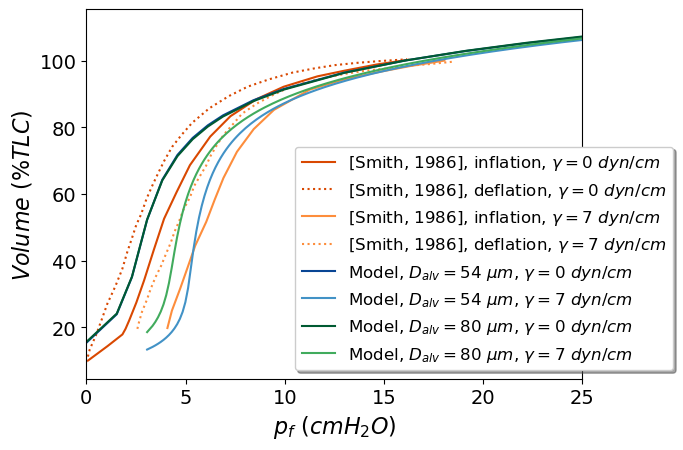

In [22]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$p_f~(cm H_2O)$', fontsize=16)
plt.ylabel(r'$Volume~(\% TLC)$', fontsize=16)

plt.plot(p_smith_gamma_0_inf, v_smith_gamma_0_inf, '#D94801', label='[Smith, 1986], inflation, $\gamma = 0~dyn/cm$')
plt.plot(p_smith_gamma_0_def, v_smith_gamma_0_def, '#D94801', linestyle='dotted', label='[Smith, 1986], deflation, $\gamma = 0~dyn/cm$')
plt.plot(p_exp_gamma_7, v_exp_gamma_7, '#FD8D3C', label='[Smith, 1986], inflation, $\gamma = 7~dyn/cm$')
plt.plot(p_gamma_7_def, v_gamma_7_def, '#FD8D3C', linestyle='dotted', label='[Smith, 1986], deflation, $\gamma = 7~dyn/cm$')

plt.plot(pf_gamma_0_lst, vf_gamma_0_lst, '#084594', label='Model, $D_{alv} = 54~\mu m$, $\gamma = 0~dyn/cm$')
plt.plot(pf_gamma_7_lst, vf_gamma_7_lst,'#4292C6', label='Model, $D_{alv} = 54~\mu m$, $\gamma = 7~dyn/cm$')

plt.plot(pf_gamma_0_lst_small, vf_gamma_0_lst_small, '#005A32', label='Model, $D_{alv} = 80~\mu m$, $\gamma = 0~dyn/cm$')
plt.plot(pf_gamma_7_lst_small, vf_gamma_7_lst_small,'#41AB5D', label='Model, $D_{alv} = 80~\mu m$, $\gamma = 7~dyn/cm$')

plt.xlim(0, 25)
plt.legend(loc = 'lower right', fontsize=12, bbox_to_anchor=(1.2, 0.), shadow=True)
plt.savefig('RVE_size_surface_tension.pdf',bbox_inches='tight')